In [48]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()
import pandas as pd

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
import re
#import networkx

from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
import collections

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [3]:
# load data
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls,'Requirements List')

In [4]:
# data shape
print("Shape of df is: ", df.shape)
print(sum(df['Standard mapping?'].isna())/df.shape[0]*100, "percent of data doesn't get mapped to a lable.")
print(df.value_counts('Mapped to a standard?'))

Shape of df is:  (10232, 13)
61.82564503518374 percent of data doesn't get mapped to a lable.
Mapped to a standard?
No mapping              6326
Mapped to a standard    3906
dtype: int64


In [5]:
# data preprocess
df1 = df[df['Mapped to a standard?'] != 'No mapping']
df1.reset_index(drop=True, inplace=True)
df1['Standard mapping?'].replace('\n',',', regex=True,inplace = True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.replace(r'^[\s,]+|[\s,]+$|(\s)*(,)[\s,]*', r'\2\1', regex=True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.split(',')

In [6]:
n = df1.shape[0]
for i in range(n):
    for j in range(len(df1['Standard mapping?'][i])):
        if df1['Standard mapping?'][i][j].lower() == 'vmp':
            df1['Standard mapping?'][i][j] = 'VMP'

# number of samples by category

In [7]:
df2 = df1.copy()

In [8]:
labels_dict = {}
for i in range(df2.shape[0]):
    for j in range(len(df2['Standard mapping?'][i])):
        label = df2['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(labels_dict.keys()):
            labels_dict[label] = 1
        else:
            labels_dict[label] += 1

In [44]:
label_count= pd.DataFrame(labels_dict.items(),columns=['label','frequency']).sort_values(by='frequency',ascending=False)
label_count = label_count.reset_index(drop=True)

In [9]:
sorted_dict = dict(sorted(labels_dict.items(), key=lambda item: item[1]))

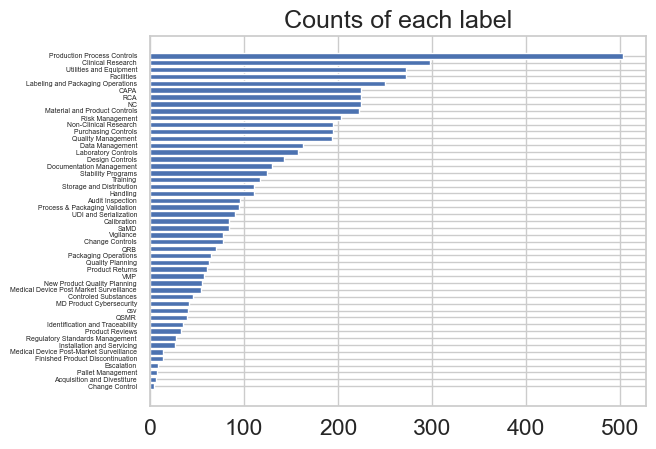

In [10]:
import matplotlib.pyplot as plt

names = list(sorted_dict.keys())
values = list(sorted_dict.values())

plt.barh(range(len(labels_dict)), values, tick_label=names)
plt.yticks(fontsize=5)
plt.title('Counts of each label')
plt.show()

### number of samples by category for each Regulatory Requirement Type

In [11]:
df1.value_counts('Regulatory Requirement Type')

Regulatory Requirement Type
Core        3049
Non-Core     508
Non-core     155
Obsolete     150
non-core      44
dtype: int64

In [12]:
# group Regulatory Requirement Type
map_type = {'Non-core':'Non-Core', 'non-core':'Non-Core'}
df1_map = df1.replace({'Regulatory Requirement Type':map_type})
df1_map.value_counts('Regulatory Requirement Type')

Regulatory Requirement Type
Core        3049
Non-Core     707
Obsolete     150
dtype: int64

In [13]:
#count label
def count_label(df):
    labels = df['Standard mapping?']
    cat = []
    for label in labels:
        cat = cat + label
    cat = Counter(cat)
    label_freq = pd.DataFrame.from_dict(cat, orient='index').reset_index().rename(columns={'index':'label',0:'count'})
    label_freq = label_freq.sort_values(by='count',ascending=True)
    return label_freq
count_label_core = count_label(df1_map[df1_map['Regulatory Requirement Type']=='Core'])
count_label_noncore = count_label(df1_map[df1_map['Regulatory Requirement Type']=='Non-Core'])
count_label_obs = count_label(df1_map[df1_map['Regulatory Requirement Type']=='Obsolete'])

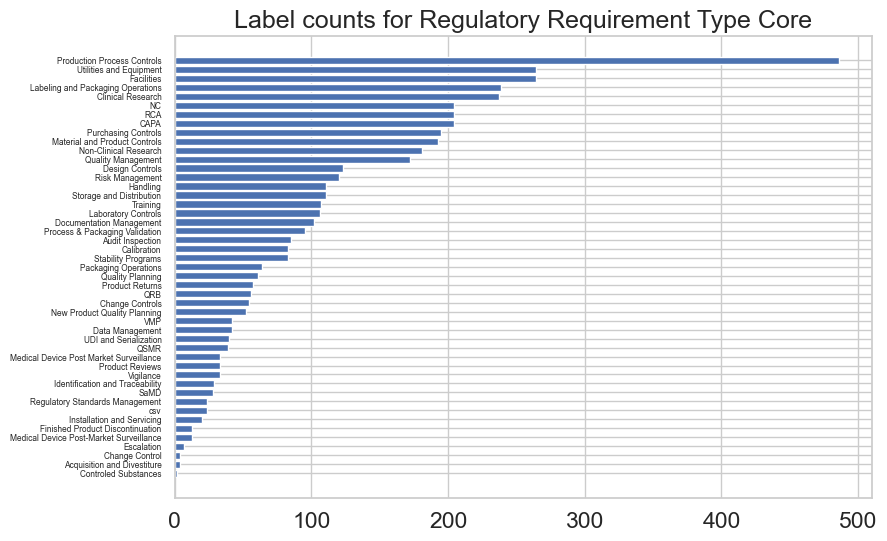

In [14]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_core['label'],width=count_label_core['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type Core')
plt.show()

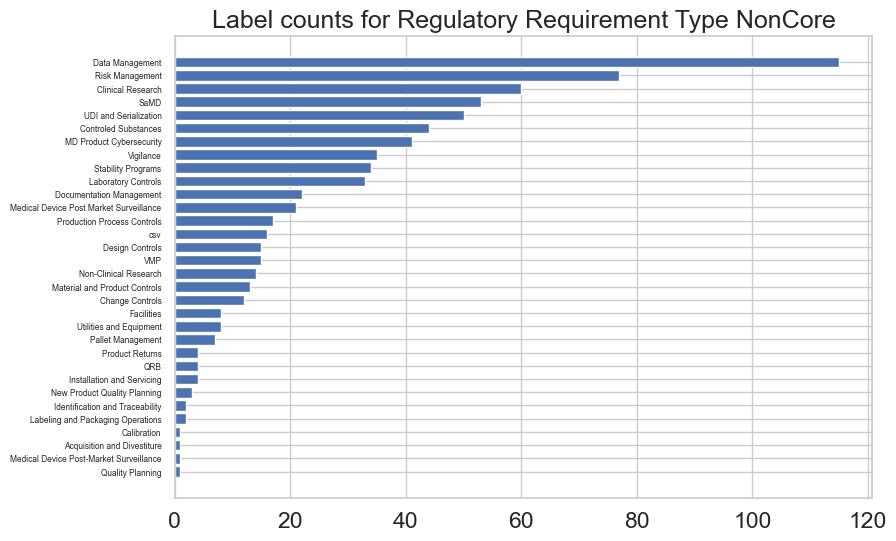

In [15]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_noncore['label'],width=count_label_noncore['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type NonCore')
plt.show()

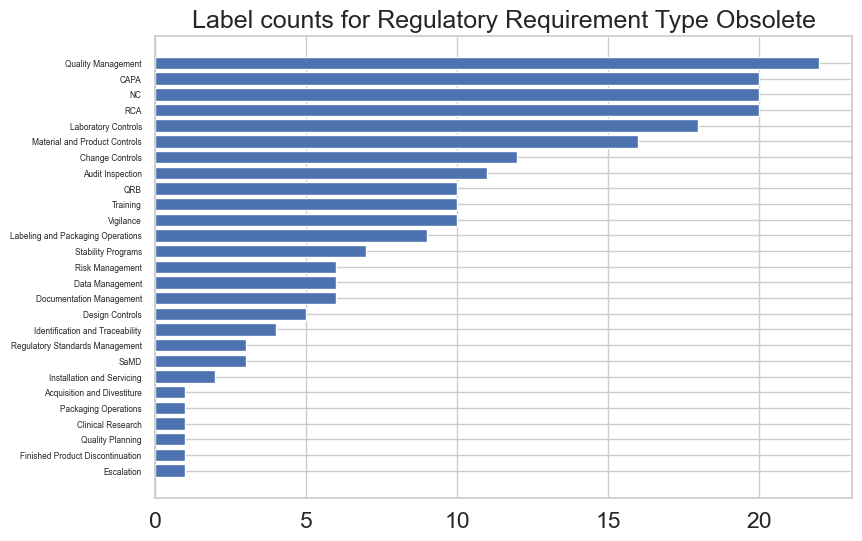

In [16]:
fig,ax = plt.subplots(figsize=(9,6))
plt.barh(y=count_label_obs['label'],width=count_label_obs['count'])
plt.yticks(fontsize=6)
plt.title('Label counts for Regulatory Requirement Type Obsolete')
plt.show()

# word frequency analysis

In [17]:
# extract all the words from text, not including numbers
df3 = df2.copy()
for i in range(df3.shape[0]):
    df3['Text'][i] = " ".join(re.sub("([^A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    #df3['Text'][i] = " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", df3['Text'][i]).split())
    df3['Text'][i] = df3['Text'][i].lower().split()
    words = df3['Text'][i]   

In [18]:
# exclude all the stop_words including 'shall'
stop_words = set(stopwords.words('english'))
df3['Text'] = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in df3['Text']]
df3['Text'] = [[word for word in tweet_words if word != 'shall']
              for tweet_words in df3['Text']]

In [19]:
texts = df3['Text']
all_words = list(itertools.chain(*texts))
counts_words = collections.Counter(all_words)
counts_words.most_common(15)

[('quality', 2243),
 ('product', 1661),
 ('control', 1308),
 ('device', 1248),
 ('data', 1127),
 ('products', 1110),
 ('materials', 991),
 ('management', 983),
 ('system', 968),
 ('procedures', 866),
 ('appropriate', 865),
 ('requirements', 864),
 ('production', 863),
 ('manufacturer', 859),
 ('process', 856)]

Text(0.5, 1.0, 'Common Words Found in Texts (Without Stop Words)')

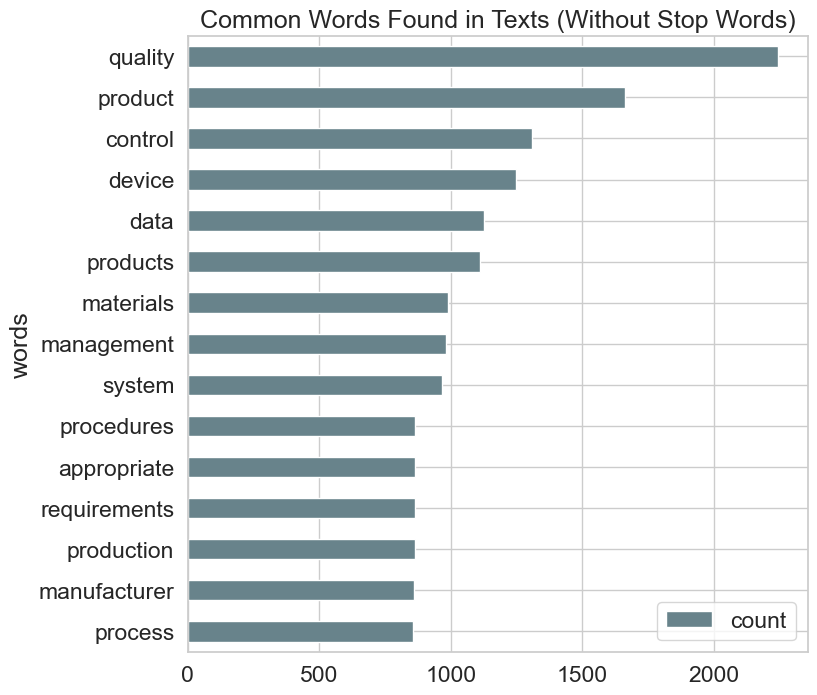

In [20]:
clean_texts = pd.DataFrame(counts_words.most_common(15),
                             columns=['words', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_texts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="#68838B")
ax.set_title("Common Words Found in Texts (Without Stop Words)")


# sentence length analysis

In [21]:
names = list(sorted_dict.keys())
values = list(sorted_dict.values())

In [22]:
lengths = []
counts = []
for name in names:
    count = 0
    length = 0
    for i in range(len(df2['Text'])):
        if name in df2['Standard mapping?'][i]:
            count += 1
            length += len(df2['Text'][i])
    counts.append(count)
    lengths.append(length)          

In [23]:
avg_len = []
for i in range(len(names)):
    if counts[i] == 0:
        print(counts[i])
        avg_len.append(0)
    else:
        avg_len.append(round(lengths[i]/counts[i],2))

In [24]:
data_tuples = list(zip(names,avg_len))
df_len = pd.DataFrame(data_tuples, columns=['labels','avg_len'])

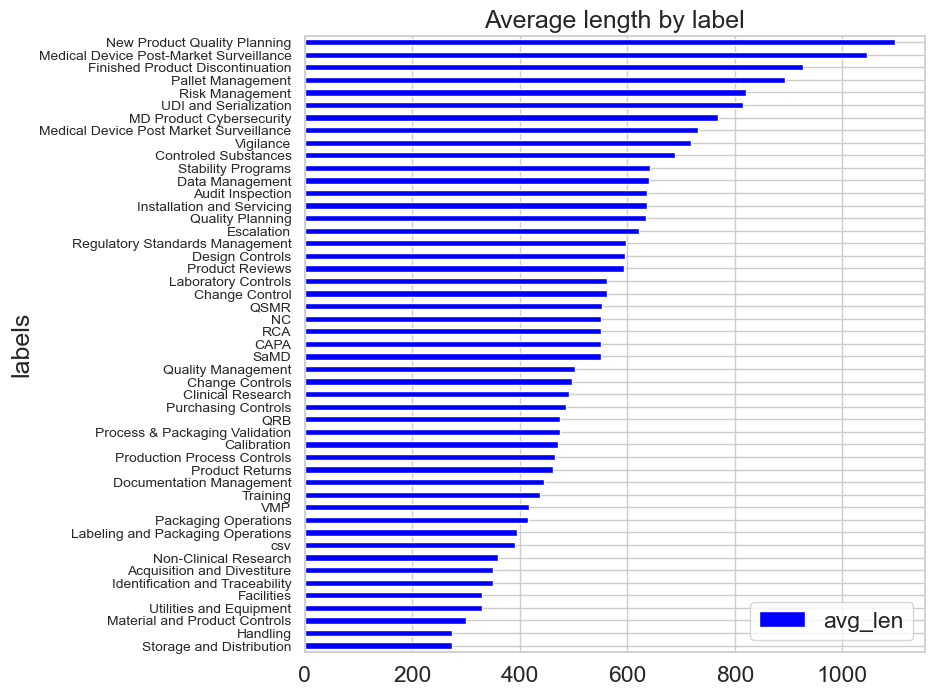

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
df_len.sort_values(by='avg_len').plot.barh(x='labels',y='avg_len',ax=ax,
                                         color="blue")
ax.set_title("Average length by label")
ax.yaxis.set_tick_params(labelsize=10)

# distribution of length

In [26]:
df4 = df3.copy()
text_length = []
for i in range(len(df4['Text'])):
    text_length.append(len(df4['Text'][i]))
df4['Text_length'] = text_length

Text(0, 0.5, 'Counts')

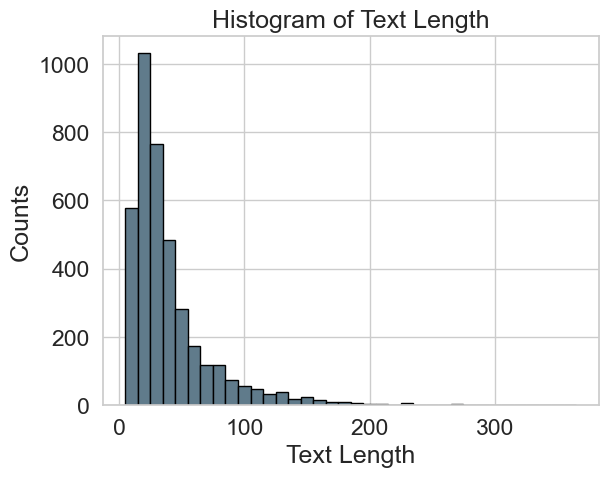

In [27]:
# matplotlib histogram
plt.hist(df4['Text_length'], color = '#607B8B', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Counts')


In [28]:
print("test")

test


# N-gram

In [29]:
import re
import nltk
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df1['Text_clean'] = df1.Text.apply(clean_text)

In [30]:
statement = df1['Text_clean'].str.split()
statement=statement.values.tolist()
corpus=[word for i in statement for word in i]
counter=Counter(corpus)
word_freq=counter.most_common()

words, counts = [], []
for word,count in word_freq[:20]:
    words.append(word)
    counts.append(count)


In [31]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
top_n_bigrams4 = get_top_ngram(df1['Text_clean'],4)[:20] 
ngram_4, count_4 = map(list,zip(*top_n_bigrams4)) 
top_n_bigrams3=get_top_ngram(df1['Text_clean'],3)[:20] 
ngram_3, count_3 = map(list,zip(*top_n_bigrams3)) 
top_n_bigrams2 = get_top_ngram(df1['Text_clean'],2)[:20] 
ngram_2, count_2 = map(list,zip(*top_n_bigrams2)) 

<Figure size 2000x2500 with 0 Axes>

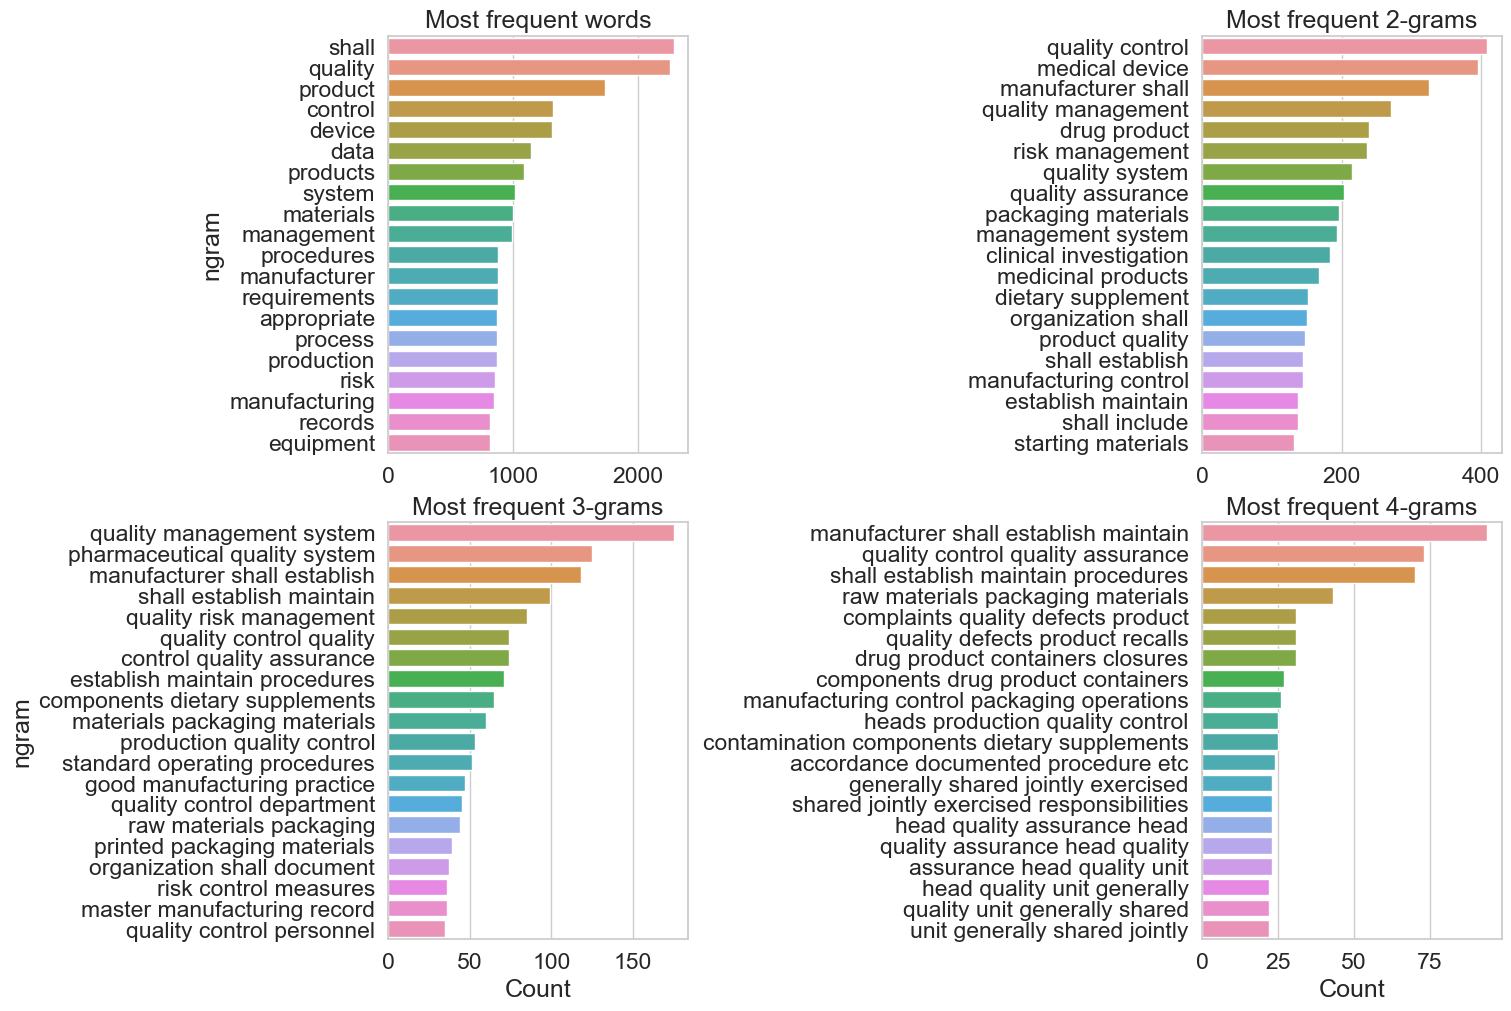

In [32]:
fig = plt.figure()
fig.set_figheight(25) 
fig.set_figwidth(20)
fig,ax = plt.subplots(2, 2, figsize = (15,10), constrained_layout=True)

sns.barplot(x=counts[:20],y=words[:20],ax=ax[0,0])
ax[0,0].set_ylabel('ngram')
ax[0,0].set_title('Most frequent words')

sns.barplot(x=count_2,y=ngram_2, ax=ax[0,1])
ax[0,1].set_title('Most frequent 2-grams')

sns.barplot(x=count_3,y=ngram_3, ax=ax[1,0])
ax[1,0].set_xlabel('Count')
ax[1,0].set_ylabel('ngram')
ax[1,0].set_title('Most frequent 3-grams')

sns.barplot(x=count_4,y=ngram_4, ax=ax[1,1])
ax[1,1].set_xlabel('Count')
ax[1,1].set_title('Most frequent 4-grams')

plt.show()

## N grams for top 3 frequent labels

In [36]:
df5 = df2.copy()
df5.head()

,id,Regulation,Title / Chapter / Sub part,Chapter / Section,Article / Paragraph,Text,Date,Product Type,GxP,Regulatory Requirement Type,Full article reference,Mapped to a standard?,Standard mapping?
0,1,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.1. General Provisions,2.1.1,General Quality System Requirements […] Genera...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.1.1,Mapped to a standard,[Regulatory Standards Management]
1,2,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.1,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.1,Mapped to a standard,"[Quality Planning, Quality Management]"
2,3,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.2,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.2,Mapped to a standard,[Quality Management]
3,4,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.3,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.3,Mapped to a standard,[Quality Management]
4,5,Brazil ANVISA GMP MD,Chapter 2 General Quality System Requirements,2.2. Management responsibility,2.2.4,General Quality System Requirements […] Manage...,2013-03-28 00:00:00,Medical Device,GMP,Core,Brazil ANVISA GMP MD 2.2.4,Mapped to a standard,"[Training, SaMD, Quality Management]"


In [37]:
df5.Text = df5.Text.str.replace(r'[^A-Za-z0-9 ]+', '')
df5.Text = df5.Text.str.lower()

In [38]:
sentence_dict = {}
for i in range(df5.shape[0]):
    for j in range(len(df5['Standard mapping?'][i])):
        label = df5['Standard mapping?'][i][j].strip()
        if label == '':
            continue
        if label not in list(sentence_dict.keys()):
            sentence_dict[label] = df5["Text"][i] 
        else:
            sentence_dict[label] += " "
            sentence_dict[label] += df5["Text"][i]

In [39]:
def word_frequency(sentence):
# creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    #counts the words, pairs and trigrams
    counted = collections.Counter(new_tokens)
    counted_2= collections.Counter(ngrams(new_tokens,2))
    counted_3= collections.Counter(ngrams(new_tokens,3))
    #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq, word_pairs, trigrams

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

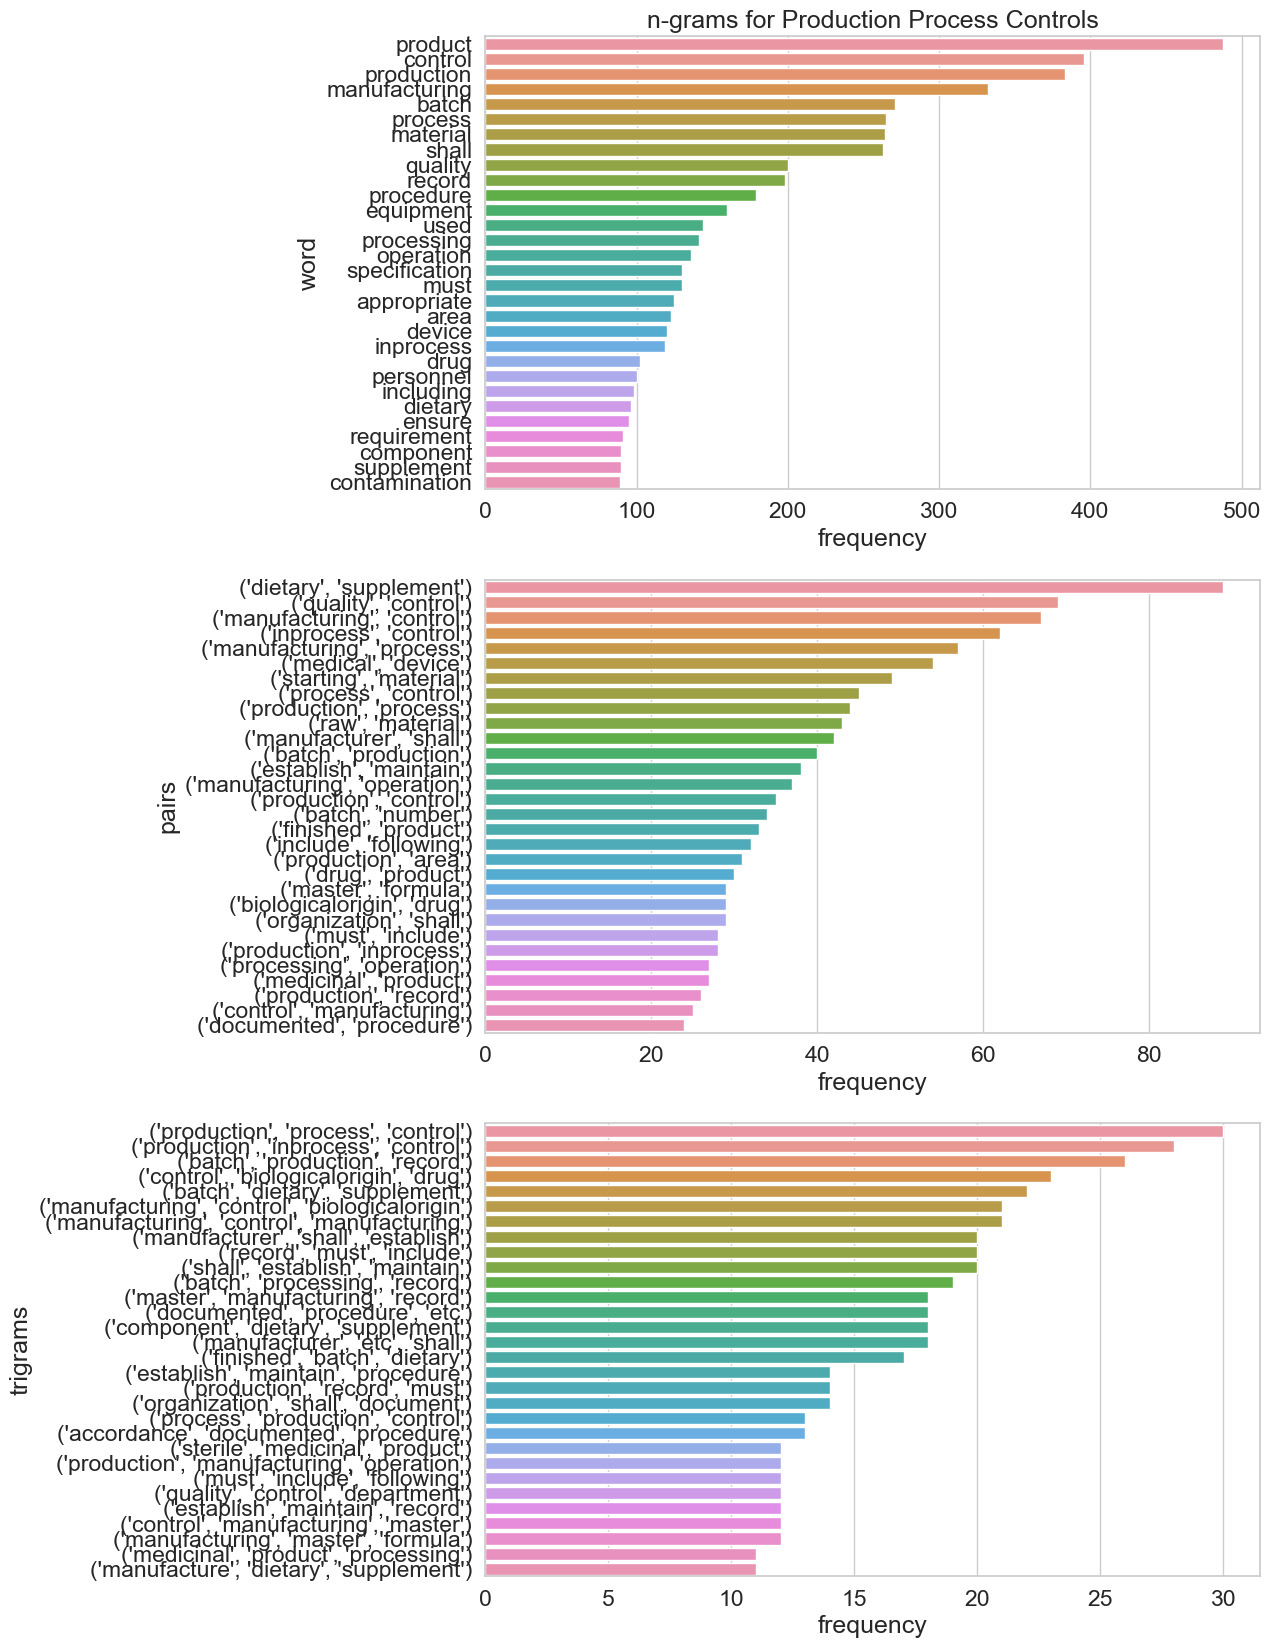

In [50]:
word_freq, word_pairs, trigrams=word_frequency(sentence_dict.get(label_count["label"][0]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30)).set(title='n-grams for ' + label_count["label"][0])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

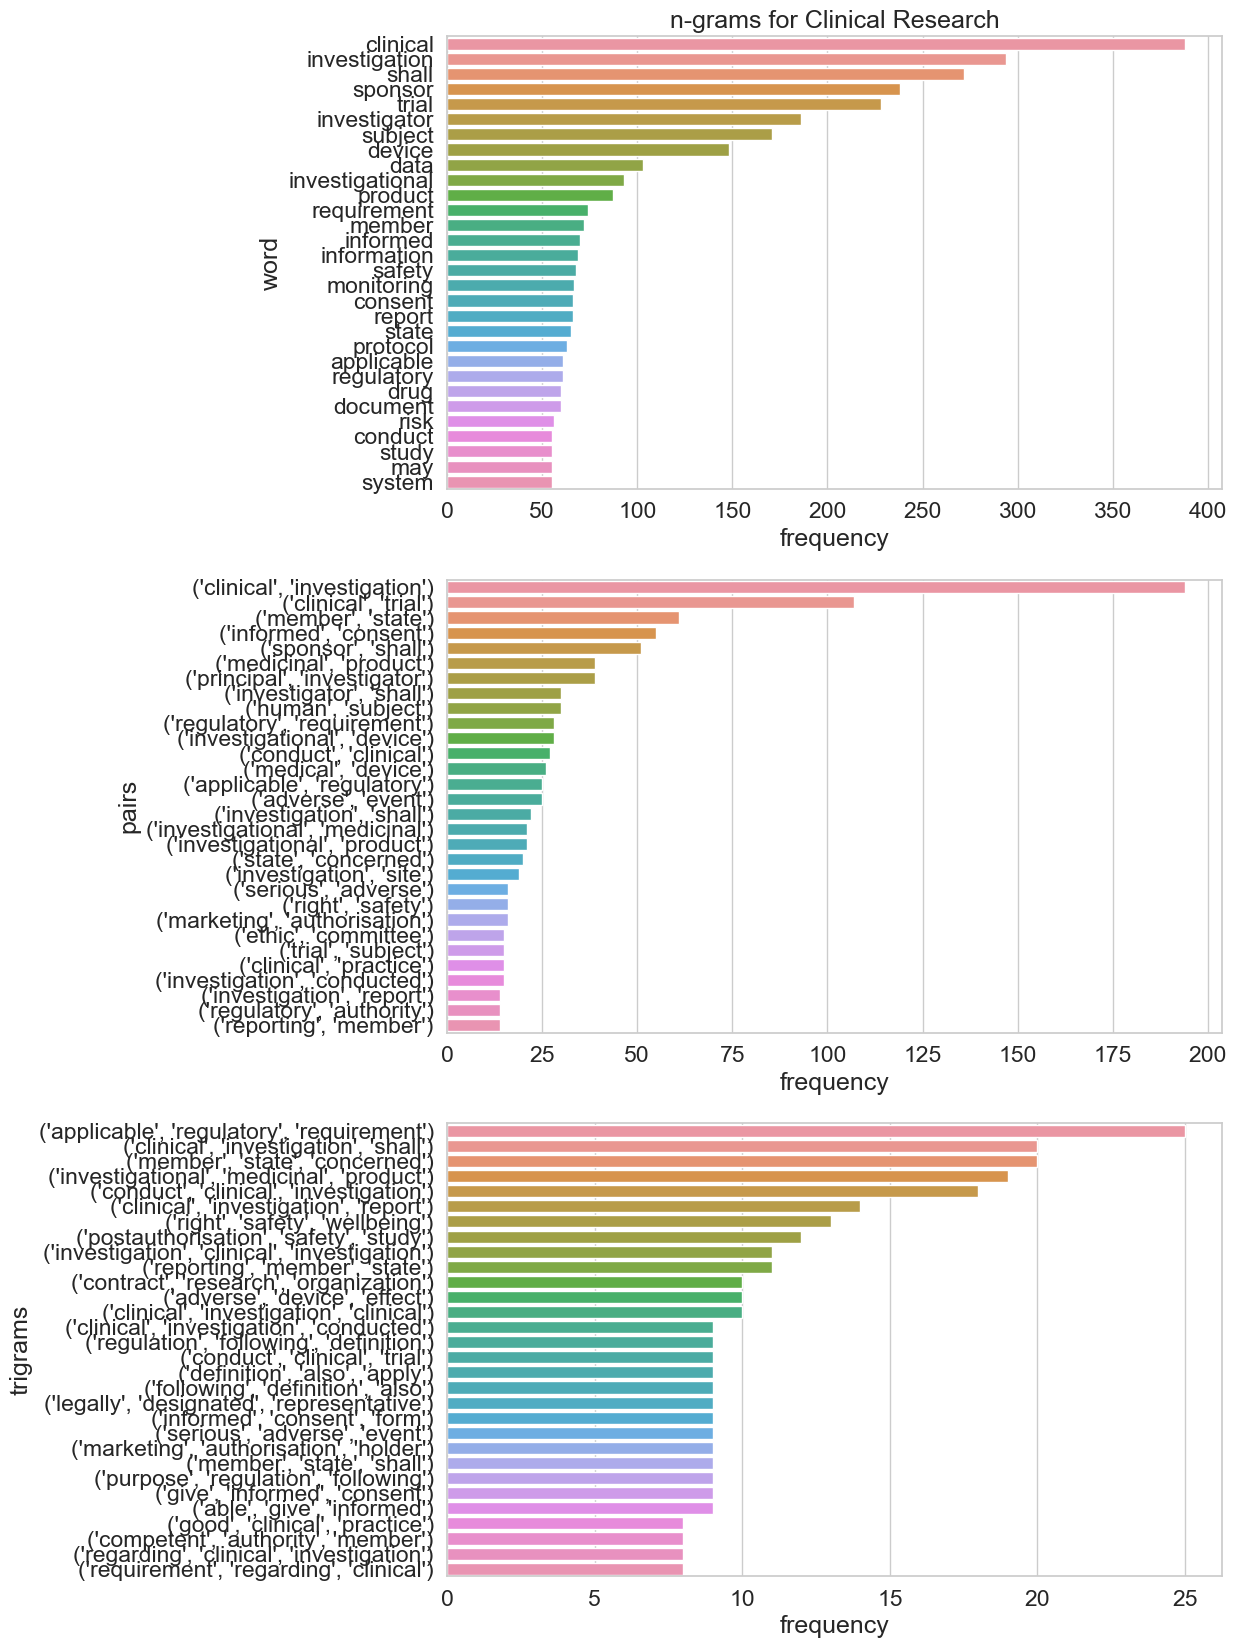

In [51]:
word_freq1, word_pairs1, trigrams1=word_frequency(sentence_dict.get(label_count["label"][1]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq1.head(30)).set(title='n-grams for ' + label_count["label"][1])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs1.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams1.head(30))

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

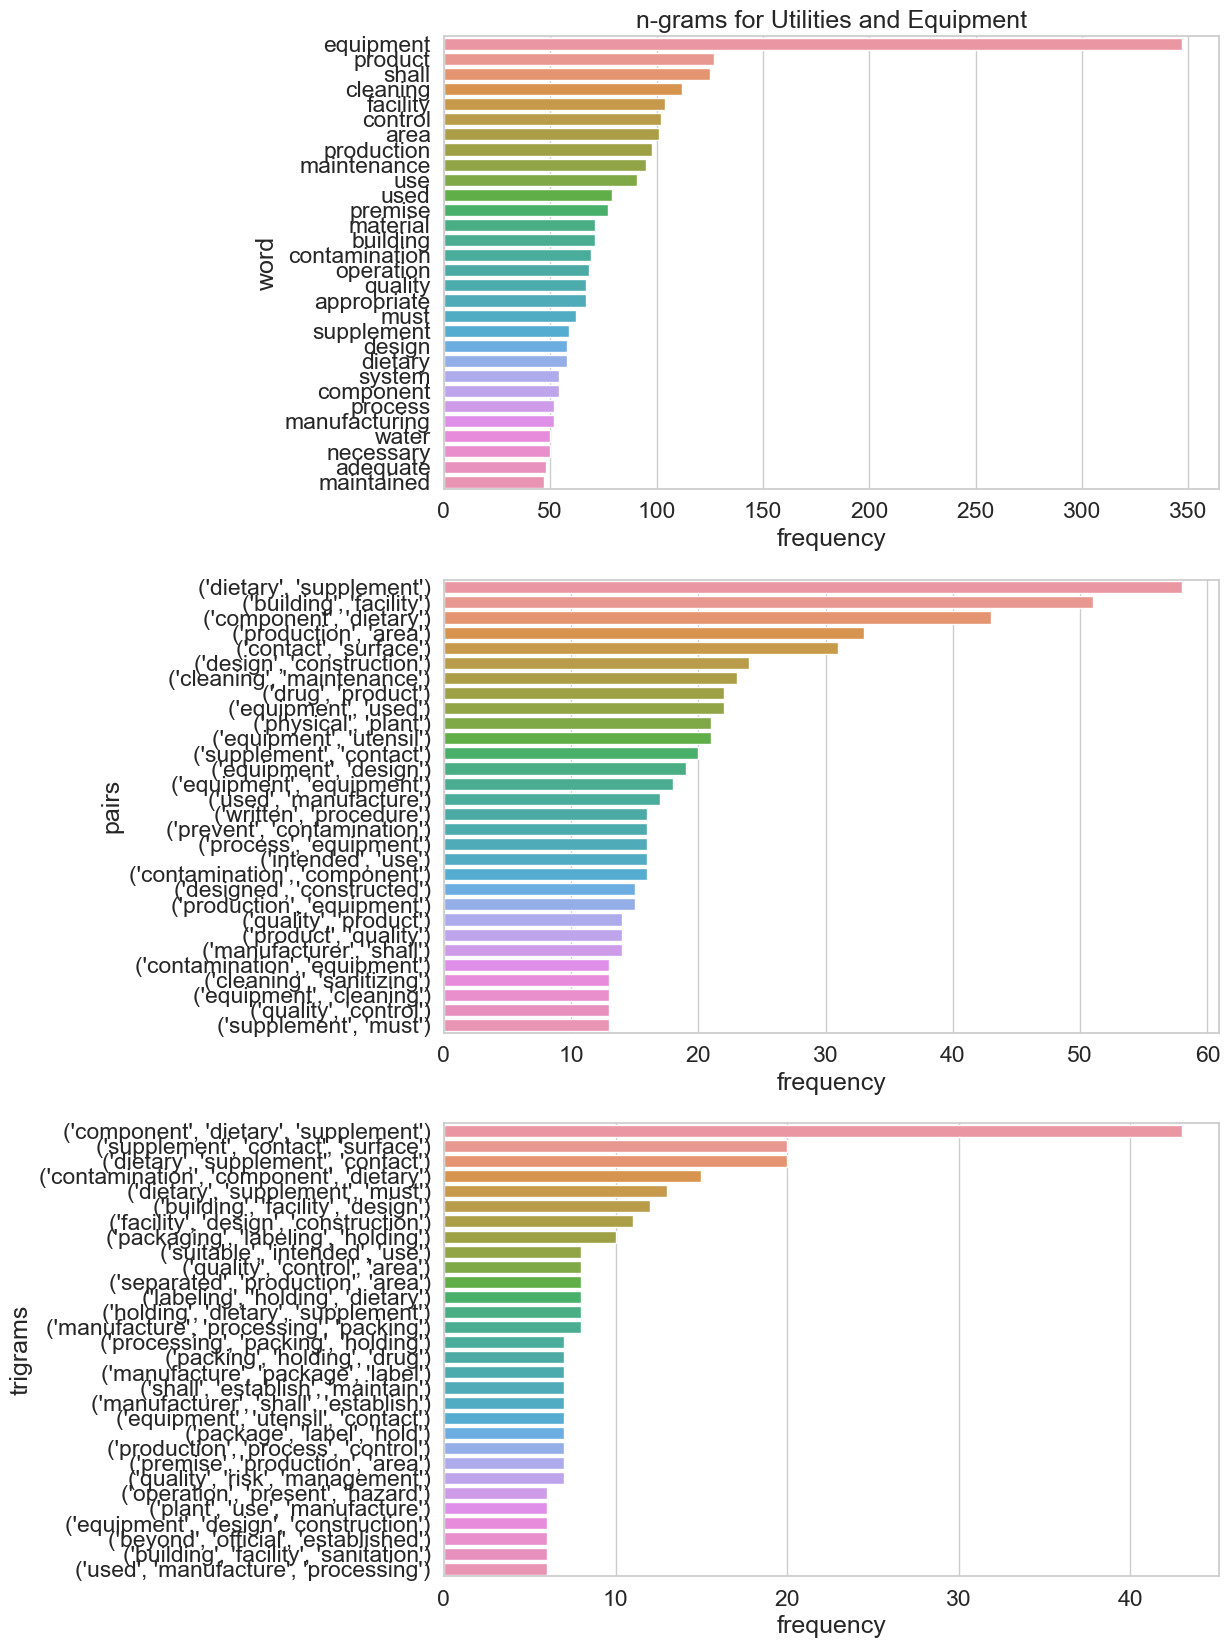

In [52]:
word_freq2, word_pairs2, trigrams2=word_frequency(sentence_dict.get(label_count["label"][2]))
fig, axes = plt.subplots(3,1,figsize=(10,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq2.head(30)).set(title='n-grams for ' + label_count["label"][2])
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs2.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams2.head(30))